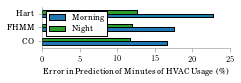

In [24]:
import numpy as np
import pandas as pd
from os.path import join
import os
from pylab import rcParams
import matplotlib.pyplot as plt

import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM, Hart85
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../common")
sys.path.append("../../common")
sys.path.append("../../../common")



%matplotlib inline
sys.path.append("../../code/common")
paths = {"Hart": "../../data/hvac/minutes_N2_K3_T50_Hart.csv",
        "CO":"../../data/hvac/minutes_N2_K3_T50_CO.csv",
        "FHMM":"../../data/hvac/minutes_N2_K3_T50_FHMM.csv",
        "Submetered":"../../data/hvac/minutes_GT.csv"}

dfs = {}
for algo, algo_csv in paths.iteritems():
    dfs[algo] = pd.read_csv(algo_csv)
    dfs[algo].index = dfs[algo].dataid
    dfs[algo] = dfs[algo].dropna()
ix = dfs["Submetered"].index

for algo, algo_df in dfs.iteritems():
    ix = algo_df.index.intersection(ix)

a_1 = {}
a_3 = {}
evening_energy = {}
morning_mins = {}
night_mins = {}
for algo, algo_df in dfs.iteritems():
    a_1[algo] = algo_df.ix[ix]["a1"]
    evening_energy[algo] = algo_df.ix[ix]["evening_energy"]
    a_3[algo] = algo_df.ix[ix]["a3"]
    morning_mins[algo] = algo_df.ix[ix]["morning_mins"]
    night_mins[algo] = algo_df.ix[ix]["sleep_mins"]
    
    
pd.DataFrame(evening_energy).plot(kind="box")
morning_df = pd.DataFrame(morning_mins)
evening_energy = pd.DataFrame(evening_energy)
Wm_to_kwh = 1.66666667 * 1e-5
def wm_to_kwh_per_month(wm, mins=24*30*60):
    return wm * Wm_to_kwh / (mins * 1.0 / (1440 * 30))

evening_energy = pd.DataFrame(evening_energy).apply(wm_to_kwh_per_month)

out = {"CO":{}, "FHMM":{},"Hart":{}}
for algo in ["CO", "FHMM", "Hart"]:
    out[algo]["Morning"] = (morning_mins[algo] - morning_mins["Submetered"]).abs().div(morning_mins["Submetered"]).mul(100).median()
    out[algo]["Night"] = (night_mins[algo] - night_mins["Submetered"]).abs().div(night_mins["Submetered"]).mul(100).median()
#plt.ylim((0,200))
#x_line = evening_energy["Submetered"]
#plt.plot(x_line, 1.2*x_line)
#plt.plot(x_line, 0.8*x_line)

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
from common_functions import latexify, format_axes
latexify(fig_height=1.2)
ax = pd.DataFrame(out).T.plot(kind="barh",rot=0, colors=[tableau20[0], tableau20[4]])
format_axes(ax)
#plt.xlabel(r"Mean absolute error")
plt.xlabel("Error in Prediction of Minutes of HVAC Usage (\%)")
#plt.xlabel("$\\frac{|Submetered\,mins-Predicted\,mins| \\times 100 \%}{Submetered\,\,mins}$")
plt.legend(loc='upper left', ncol=1)
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/nilm-actionable/figures/hvac/mins.pdf", bbox_inches="tight")